# Как узнать свою аудиторию? 
## Построение различных вариантов кластеризаций и интерпретация результатов.

### Content
* [Подготовка к работе](#preload)
* [EDA, Preprocessing & Feature Engineering](#eda)
  * [Общий обзор данных](#eda_preview)
  * [Оценка NaN значений](#eda_nan)
  * [Оценка категориальных признаков](#eda_catfeat)
  * [Масштабирование](#scaling)
  * [Визуальный анализ](#eda_visual)
* [Models и выводы](#model)
  * [K-Means](#model_kmeans)
  * [Hierarhical](#model_hierarhical)
  * [DBSCAN](#model_dbscan)
  * [Снижение размерности](#red_dim)

## Подготовка к работе <a class="anchor" id="preload"/>

In [1]:
# preload local libs
import sys
import os
import pathlib

project_dir = str(pathlib.Path(os.getcwd()).parent.resolve())
if project_dir not in sys.path:
    sys.path.insert(1, project_dir)

# project_dir

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

import kagglehub

from lib import utils

import warnings

warnings.filterwarnings("ignore")

In [3]:
dataset_dir = project_dir + '/datasets/uciml/german-credit'

In [4]:
# Копирование данных из Kaggle в локальный каталог. Делается один раз
import shutil

path = kagglehub.dataset_download("uciml/german-credit")
# print("Path to dataset files:", path)

shutil.rmtree(dataset_dir, True)
shutil.copytree(path, dataset_dir)
shutil.rmtree(path)

100%|██████████| 10.9k/10.9k [00:00<00:00, 4.91MB/s]

Extracting files...


In [5]:
df_src = pd.read_csv(dataset_dir + "/german_credit_data.csv", delimiter=",")

df = df_src.copy()
df.columns.values[0] = 'ID'
# сразу удалим ID, как неинформативную
df.drop(columns=['ID'], inplace=True)

## EDA <a class="anchor" id="eda"/>

### Общий обзор даных <a class="anchor" id="eda_preview"/>

In [6]:
df.head(20)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car
5,35,male,1,free,NaN,NaN,9055,36,education
6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment
7,35,male,3,rent,little,moderate,6948,36,car
8,61,male,1,own,rich,NaN,3059,12,radio/TV
9,28,male,3,own,little,moderate,5234,30,car


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [8]:
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [9]:
df.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64

In [10]:
# Количество пропусков по признакам
df.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

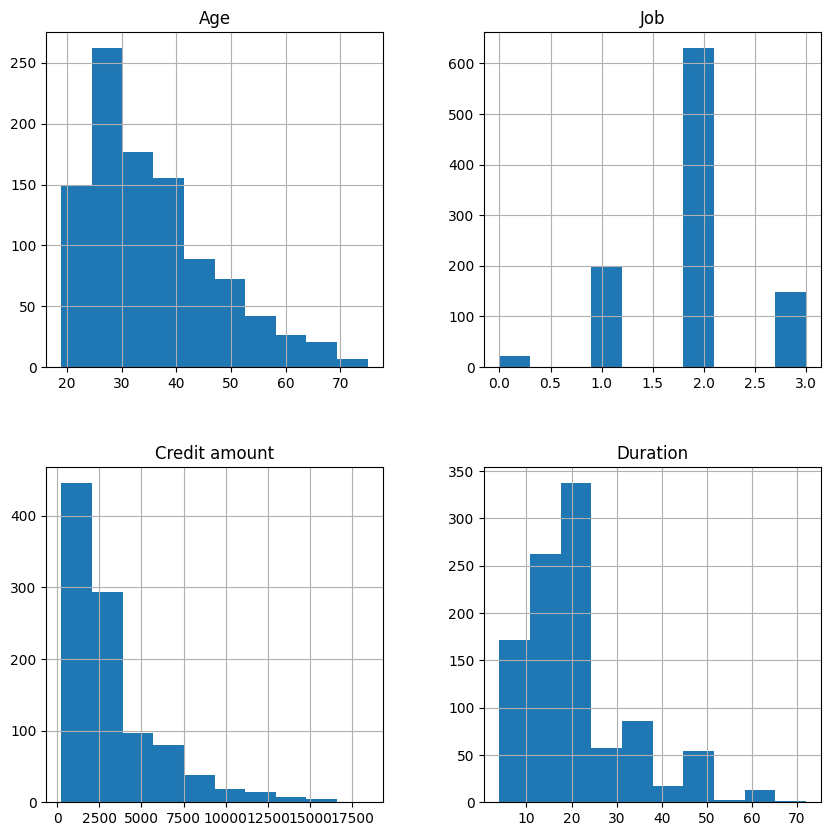

In [11]:
df.hist(figsize=(10,10));

### Оценка NaN значений <a class="anchor" id="eda_nan"/>

**Checking account**, **Saving accounts**: Отсутствие информации допустимо оценивать, как отдельную категорию.

In [12]:
df.fillna({
    'Saving accounts': 'none',
    'Checking account': 'none'
}, inplace=True)

### Оценка категориальных признаков <a class="anchor" id="eda_catfeat"/>

In [13]:
df.dtypes

Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object

In [14]:
# категориальные признаки
object_columns = df.select_dtypes(include=['object']).columns.to_list()
# числовые признаки
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.to_list()

print('Разнообразие значений категориальных переменных:')
for object_col in object_columns:
    print(f'  {object_col}:', len(df[object_col].unique()))
    if len(df[object_col].unique()) < 10:
        print('  Values:', ', '.join(df[object_col].unique().tolist()))
    print()

Разнообразие значений категориальных переменных:
  Sex: 2
  Values: male, female

  Housing: 3
  Values: own, free, rent

  Saving accounts: 5
  Values: none, little, quite rich, rich, moderate

  Checking account: 4
  Values: little, moderate, none, rich

  Purpose: 8
  Values: radio/TV, education, furniture/equipment, car, business, domestic appliances, repairs, vacation/others



Существуют различные методы кодирования категориальных признаков в числовые.

**Ordinal Encoding**: каждой категории присваивается отдельное уникальное число. Хорошо подходит для категорий, имеющих естественный порядок значений.
Применим его к "Saving accounts", "Checking account" и "Housing".\
**One-Hot Encoding**: лучшим образом подходит для кодирования признака "Purpose".\
**Binary Encoding**: для признака "Sex".

Приводить будем в ручном режиме, чтобы контролировать естественный порядок значений.

In [15]:
df_enc = df.copy(deep=True)

df_enc['Sex'] = (df_enc['Sex'] == 'male').astype(int) # 0 - F, 1 - M
df_enc['Housing'].replace({'free': 0, 'rent': 1, 'own': 2}, inplace=True)

# none, little, quite rich, rich, moderate
df_enc['Saving accounts'].replace({'none': 0, 'little': 1, 'moderate': 2, 'quite rich': 3, 'rich': 4}, inplace=True)
df_enc['Checking account'].replace({'none': 0, 'little': 1, 'moderate': 2, 'quite rich': 3, 'rich': 4}, inplace=True)

# набор без признака Purpose (No Purpose - np)
df_enc_np = df_enc.copy()
df_enc_np.drop(columns=['Purpose'], inplace=True)

df_enc = pd.get_dummies(df_enc, columns=['Purpose'], drop_first=True, dtype=int) # drop_first=True - чтобы избежать мультиколениарности

df_enc.head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,1,2,2,0,1,1169,6,0,0,0,0,1,0,0
1,22,0,2,2,1,2,5951,48,0,0,0,0,1,0,0
2,49,1,1,2,1,0,2096,12,0,0,1,0,0,0,0
3,45,1,2,0,1,1,7882,42,0,0,0,1,0,0,0
4,53,1,2,0,1,1,4870,24,1,0,0,0,0,0,0
5,35,1,1,0,0,0,9055,36,0,0,1,0,0,0,0
6,53,1,2,2,3,0,2835,24,0,0,0,1,0,0,0
7,35,1,3,1,1,2,6948,36,1,0,0,0,0,0,0
8,61,1,1,2,4,0,3059,12,0,0,0,0,1,0,0
9,28,1,3,2,1,2,5234,30,1,0,0,0,0,0,0


### Масштабирование <a class="anchor" id="scaling"/>

Рассматриваемые в задании алгоритмы машинного обучения используют в обучении метрики расстояния, которые чувствительны к величине значения признака. 
Чтобы избежать доминирования одних признаков над другими все значения приводят к одному масштабу.

#### StandardScaler

Преобразует признак так, чтобы $$x' = \frac{x−mean}{std}$$
Хорошо работает, когда данные примерно нормальны и не содержат экстремальных выбросов.

#### MinMaxScaler

Масштабирует значения в диапазон [0, 1]:
$$x' = \frac{x − x_{min}}{x_{max} - x_{min}}$$
Сохраняет форму распределения и удобен для признаков с естественными границами (возраст, доли и т.д.). Но при этом более чувствителен к выбросам, по сравнению с StandardScaler.

#### RobustScaler

Использует медиану и интерквартильный размах (то есть масштабируется относительно 25–75 перцентилей):
$$x' = \frac{x − median}{IQR}$$
Не реагирует на выбросы и сохраняет структуру основной массы данных.

#### Normalizer

Масштабирует вектор наблюдения, а не признак:
$$x' = \frac{x_i}{||x||}$$
То есть каждый объект (строка) приводится к единичной длине (норме).
Полезен, если важны направления в пространстве, а не абсолютные значения (например, при тексте, TF-IDF, косинусных расстояниях).

#### Итог

В данных нет явных выбросов, поэтому RobustScaler применять не требуется. Но при этом данные не распределены нормально или имеют выраженный в одну сторону.\
StandardScaler при ассиметричных распределениях исказит плотность распределения, растянув его в длинный "хвост".\
MinMaxScaler в этом случае сохранит форму распределения в диапазоне [0,1].\
Возможно будет разумнее сначала трансформировать распределение с помощью Log-Transform или PowerTransform / Yeo-Johnson а потом применить StandardScaler.\
Однако такой подход несколько выходит за рамки задания, поэтому **ограничимся использованием MinMaxScaler для всех признаков**.

In [16]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(df_enc)
X_scaled_np = scaler.fit_transform(df_enc_np)

data_scaled = pd.DataFrame(X_scaled, columns=df_enc.columns)
data_scaled_np = pd.DataFrame(X_scaled_np, columns=df_enc_np.columns)

data_scaled.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,0.857143,1.0,0.666667,1.0,0.00,0.25,0.050567,0.029412,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.053571,0.0,0.666667,1.0,0.25,0.50,0.313690,0.647059,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.535714,1.0,0.333333,1.0,0.25,0.00,0.101574,0.117647,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.464286,1.0,0.666667,0.0,0.25,0.25,0.419941,0.558824,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.607143,1.0,0.666667,0.0,0.25,0.25,0.254209,0.294118,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Визуальный анализ <a class="anchor" id="eda_visual"/>

Матрица корреляций

<Axes: >

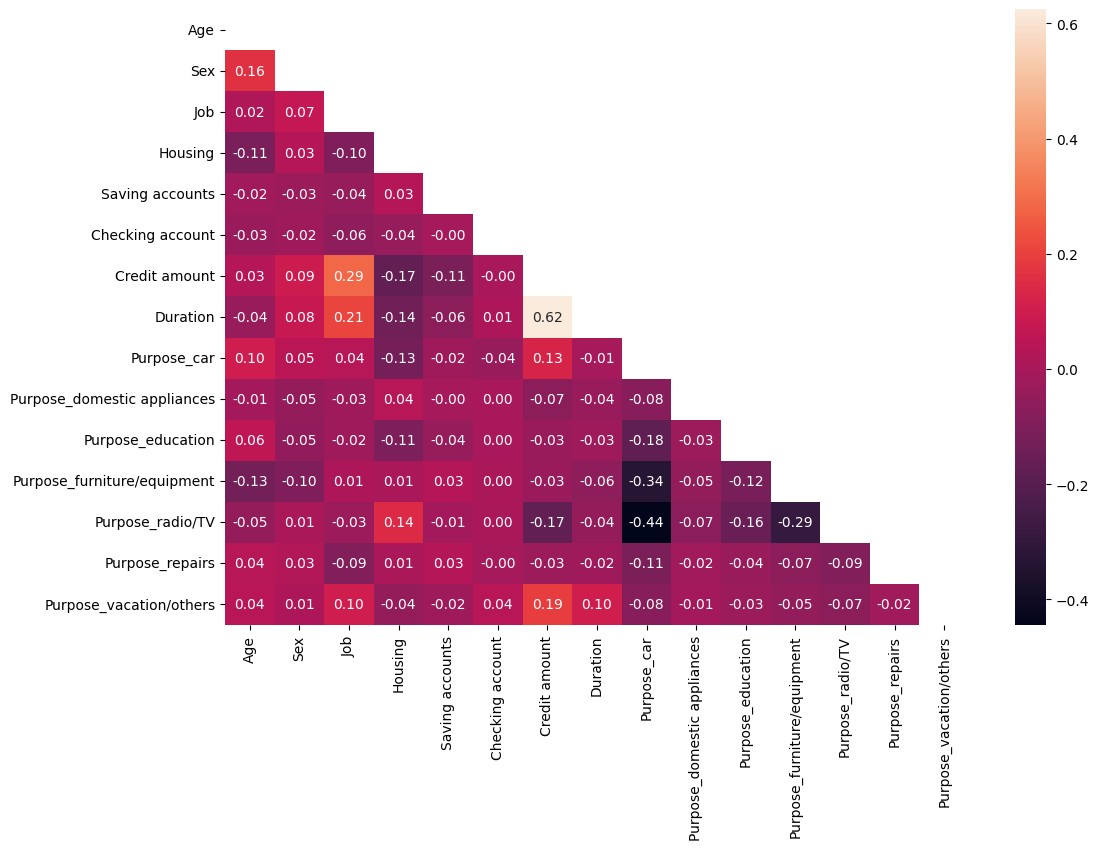

In [17]:
corr = data_scaled.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12,8))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f')

## Кластеризация <a class="anchor" id="model"></a>

### K-Means <a class="anchor" id="model_kmeans"></a>

#### Elbow method. Метод локтя

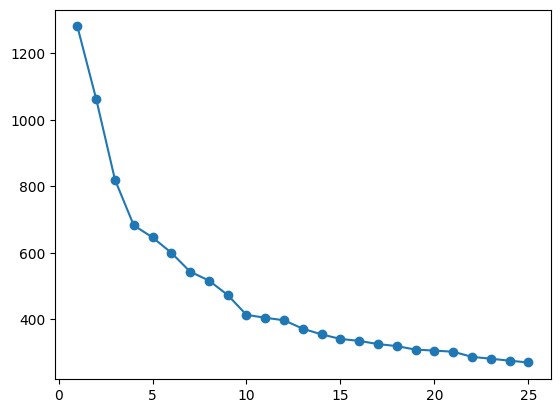

In [18]:
CLUSTERS = 25

inertia = []
for i in range(1, CLUSTERS+1):
    kmeans = KMeans(n_clusters=i, random_state=1, n_init='auto').fit(X_scaled)
    labels = kmeans.labels_
    inertia_i = kmeans.inertia_
    inertia.append(inertia_i)

plt.plot(range(1, CLUSTERS+1), inertia, marker='o');

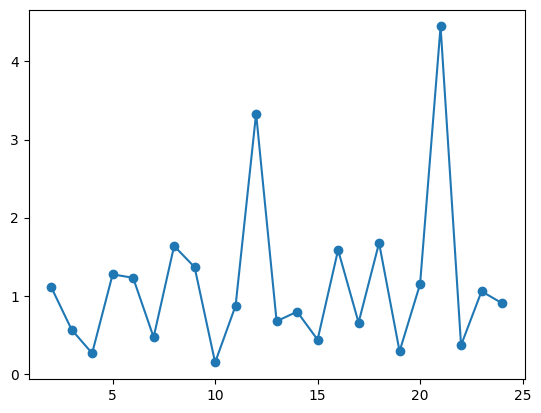

In [19]:
D = []
for i in range(1, CLUSTERS-1):
    Di = (inertia[i] - inertia[i+1]) / (inertia[i-1] - inertia[i])
    D.append(Di)

plt.plot(range(2, CLUSTERS), D, marker='o');

**Предварительный вывод:** Эксперементируя с параметрами random_state и n_init график инерции получался относительно гладким без выраженного перелома "локтя".\
Это может говорить о том, что:
* данные не имеют чёткой кластерной структуры
* имеются шумовые или нерелевантные признаки
* слишком большое количество признаков
* кластеры есть, но они не сферические, в этом случае они могут проявится в других методах.

На всякий случай проверим, что сокращение количества признаков (удален признак "Purpose", как наиболее массовый) не меняют особо картину.

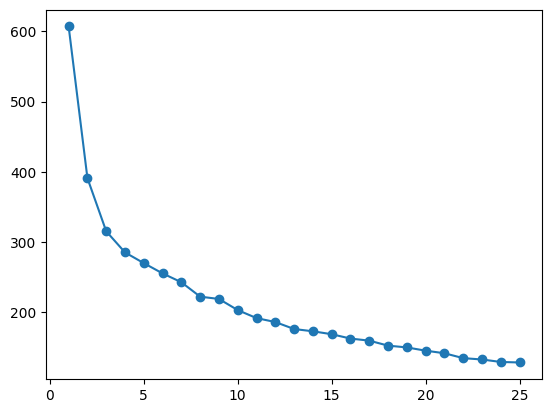

In [20]:
inertia = []
for i in range(1, CLUSTERS+1):
    kmeans = KMeans(n_clusters=i, random_state=1, n_init='auto').fit(X_scaled_np)
    labels = kmeans.labels_
    inertia_i = kmeans.inertia_
    inertia.append(inertia_i)

plt.plot(range(1, CLUSTERS+1), inertia, marker='o');

#### Silhouette method

In [21]:
silhouette = []
for i in tqdm(range(2, CLUSTERS + 1)):
    kmeans = KMeans(n_clusters=i, random_state=1, n_init='auto').fit(X_scaled)
    labels = kmeans.labels_
    score = silhouette_score(X_scaled, labels)
    silhouette.append(score)

100%|██████████| 24/24 [00:01<00:00, 12.48it/s]


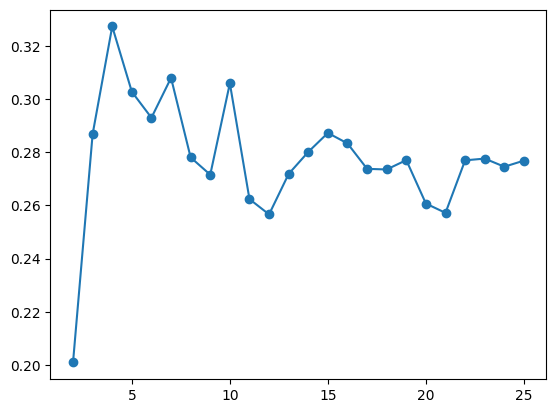

In [22]:
plt.plot(range(2, CLUSTERS + 1), silhouette, marker='o');

Как и в предыдущем случае, при изменении параметров random_state и n_init приводит к различным налилучшим значениям силуэта, однако при числе кластеров 4 наблюдается общий локальный максимум. Используем данное значение, как оптимаьный результат по количеству кластеров.

In [23]:
kmeans = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(X_scaled)
labels = kmeans.labels_

df_enc_l = df_enc.copy()
df_enc_l['labels'] = labels
df_enc_l.groupby('labels').median().T.round(2)

labels,0,1,2,3
Age,34.0,32.0,35.0,30.0
Sex,1.0,1.0,1.0,1.0
Job,2.0,2.0,2.0,2.0
Housing,2.0,2.0,2.0,2.0
Saving accounts,1.0,1.0,1.0,1.0
Checking account,1.0,1.0,1.0,1.0
Credit amount,2350.5,1890.0,2679.0,2578.0
Duration,21.0,18.0,18.0,18.0
Purpose_car,0.0,0.0,1.0,0.0
Purpose_domestic appliances,0.0,0.0,0.0,0.0


### Hierarhical <a class="anchor" id="model_hierarhical"></a>

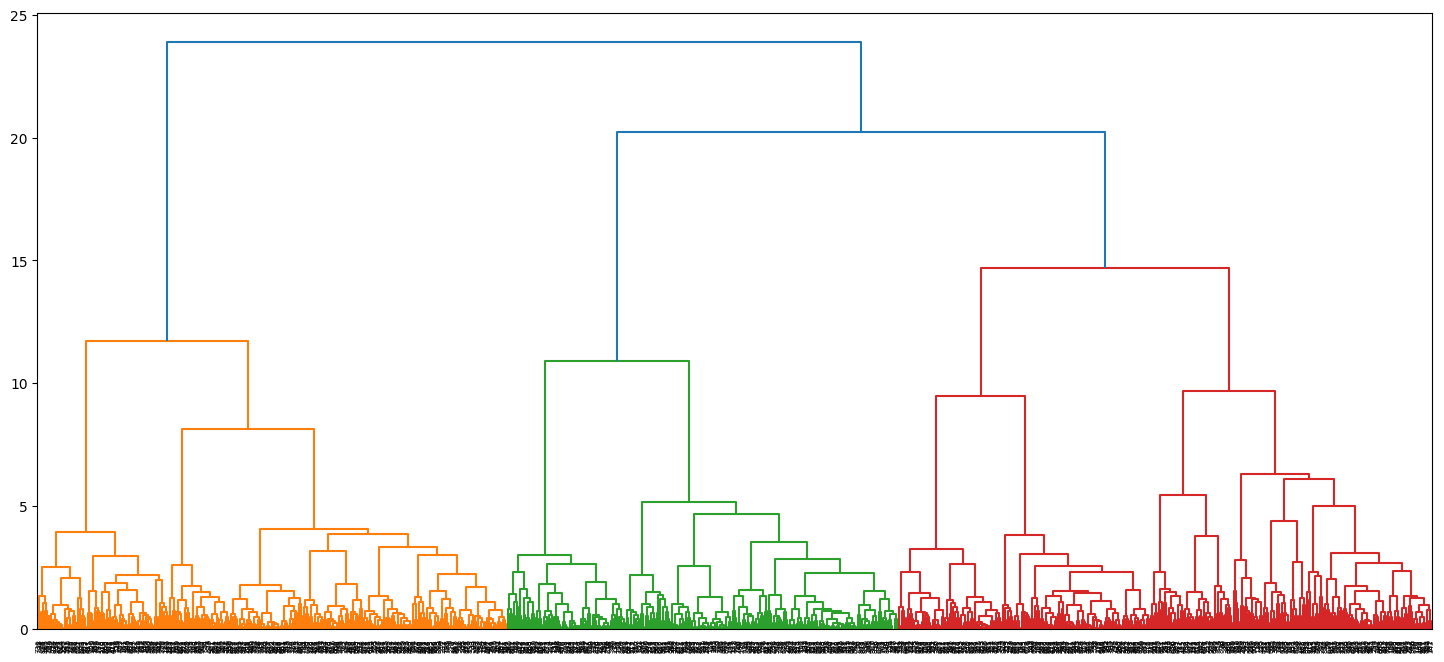

In [24]:
CLUSTERS = 20

plt.figure(figsize=(18,8))
linkage_ = linkage(X_scaled, method='ward')
dendrogram_ = dendrogram(linkage_)

100%|██████████| 19/19 [00:00<00:00, 25.88it/s]


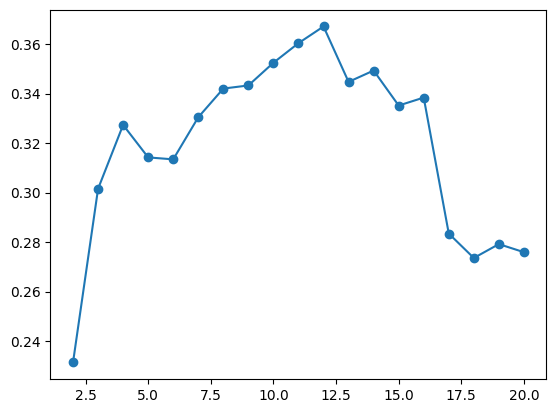

In [25]:
silhouette = []
for i in tqdm(range(2, CLUSTERS+1)):
    agg = AgglomerativeClustering(n_clusters=i, linkage='ward').fit(X_scaled)
    labels = agg.labels_
    score = silhouette_score(X_scaled, labels)
    silhouette.append(score)

plt.plot(range(2, CLUSTERS+1), silhouette, marker='o');

По величине значения кластеры выражаются не очень явно. Оптимальное число кластеров выбираем 4

In [26]:
agg = AgglomerativeClustering(n_clusters=4, linkage='ward').fit(X_scaled)
labels = agg.labels_

df_enc_l = df_enc.copy()
df_enc_l['labels'] = labels
df_enc_l.groupby('labels').median().T.round(2)

labels,0,1,2,3
Age,35.0,34.0,32.0,30.0
Sex,1.0,1.0,1.0,1.0
Job,2.0,2.0,2.0,2.0
Housing,2.0,2.0,2.0,2.0
Saving accounts,1.0,1.0,1.0,1.0
Checking account,1.0,1.0,1.0,1.0
Credit amount,2679.0,2350.5,1890.0,2578.0
Duration,18.0,21.0,18.0,18.0
Purpose_car,1.0,0.0,0.0,0.0
Purpose_domestic appliances,0.0,0.0,0.0,0.0


### DBSCAN <a class="anchor" id="model_dbscan"></a>

Рассмотрим на значениях по умолчанию

In [27]:
dbscan = DBSCAN(n_jobs=-1).fit(X_scaled)
labels = dbscan.labels_

In [28]:
uniq_labels = np.unique(labels)
uniq_labels

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22])

In [29]:
# -1 - шумовая метка, исключим ее
n_clusters = len(uniq_labels[uniq_labels != -1])
n_clusters

23

#### Silhouette method

Подберем параметры, которые влияют на выбор кластеров

In [30]:
silhouette = []
clusters = []
eps_range = np.arange(0.1, 1.5, 0.1)
for i in tqdm(eps_range):
    dbscan = DBSCAN(eps=i, n_jobs=-1, min_samples=5).fit(X_scaled)
    labels = dbscan.labels_
    uniq_labels = np.unique(labels)
    n_clusters = len(uniq_labels[uniq_labels != -1])
    if n_clusters > 1:
        score = silhouette_score(X_scaled, labels)
    else:
        score = 0
    silhouette.append(score)
    clusters.append(n_clusters)

100%|██████████| 14/14 [00:01<00:00, 12.30it/s]


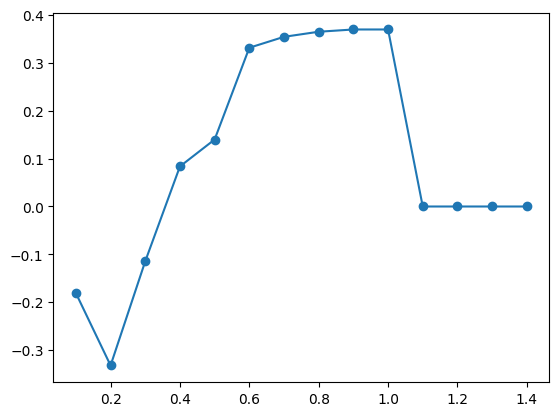

In [31]:
plt.plot(eps_range, silhouette, marker='o');

Нас интересует максимальное значение силуэтного коэффициента. По графику видно, что это диапазон значений от 0.6 до 1.
Так же построим график зависимости числа кластеров от eps.

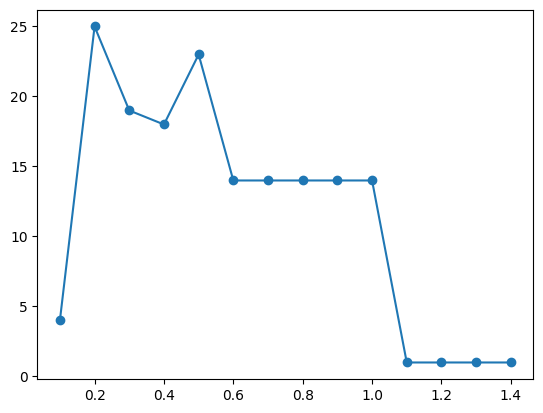

In [32]:
plt.plot(eps_range, clusters, marker='o');

На этом графике интересует диапазон стабильности значения, когда число кластеров не меняется от eps. По графику это тот же диапазон от 0.6 до 1.
Для нагрядности сведем на один график эти значения.

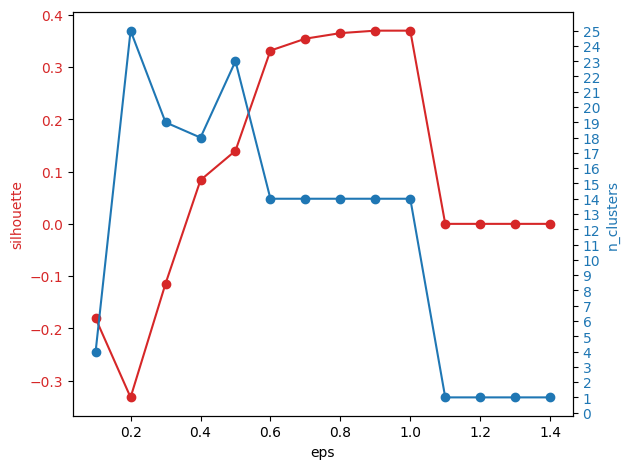

In [33]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(eps_range, silhouette, marker='o', color=color)
ax1.set_xlabel('eps')
ax1.set_ylabel('silhouette', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(eps_range, clusters, marker='o', color=color)
ax2.set_ylabel('n_clusters', color=color)  
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks(range(0, 26))

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Пусть значения будут eps=0.9 и количество кластеров будет 14

In [34]:
dbscan = DBSCAN(eps=0.9, min_samples=5, n_jobs=-1).fit(X_scaled)
labels = dbscan.labels_

df_enc_l = df_enc.copy()
df_enc_l['labels'] = labels
df_enc_l.groupby('labels').median().T.round(2)

labels,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Age,40.0,33.0,29.0,38.0,33.0,36.0,29.5,27.0,34.0,26.0,34.0,34.0,34.0,42.0,24.0
Sex,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
Job,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0
Housing,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
Saving accounts,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
Checking account,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.5,1.0,1.0
Credit amount,2631.0,1934.0,1715.0,1977.0,2828.0,2799.0,2394.5,2528.0,3507.0,2166.0,1555.0,1372.5,8821.0,1300.0,1055.0
Duration,18.0,18.0,18.0,18.0,20.0,18.0,18.0,27.0,24.0,15.0,15.0,12.0,24.0,13.5,13.5
Purpose_car,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Purpose_domestic appliances,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


**В общем и целом деление на кластеры произошли в основном по целям взятия кредита.**

In [35]:
df_enc_l['labels'].value_counts(normalize=True).sort_index()

labels
-1     0.011
 0     0.195
 1     0.085
 2     0.035
 3     0.107
 4     0.243
 5     0.094
 6     0.019
 7     0.078
 8     0.074
 9     0.017
 10    0.024
 11    0.006
 12    0.006
 13    0.006
Name: proportion, dtype: float64

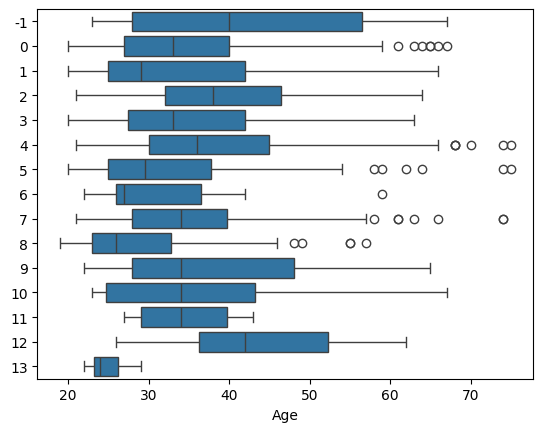

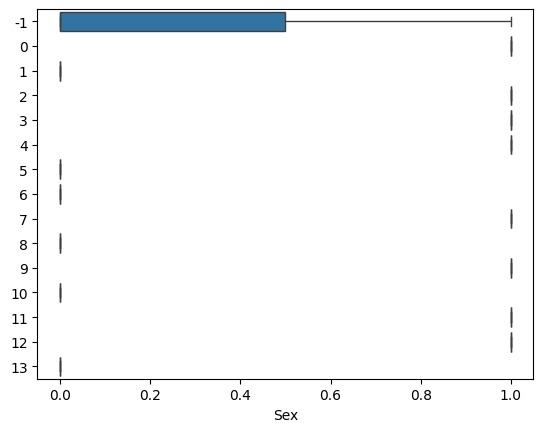

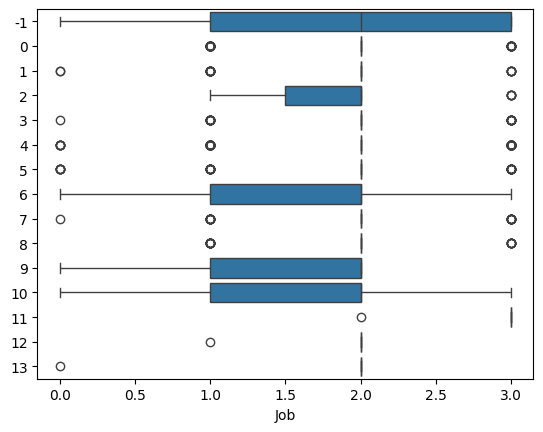

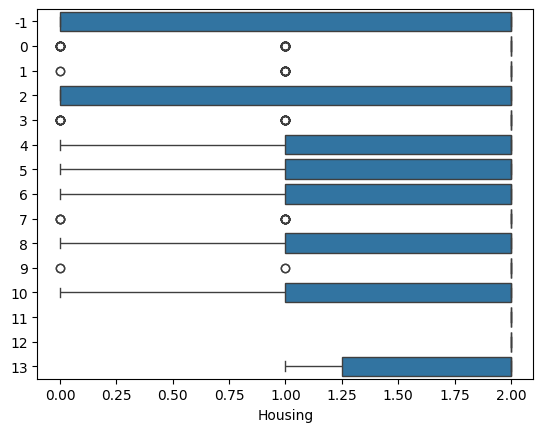

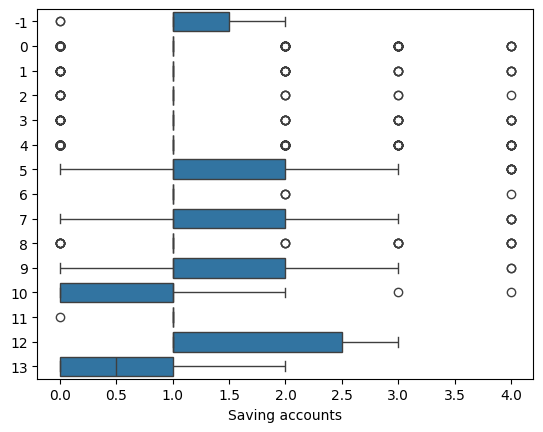

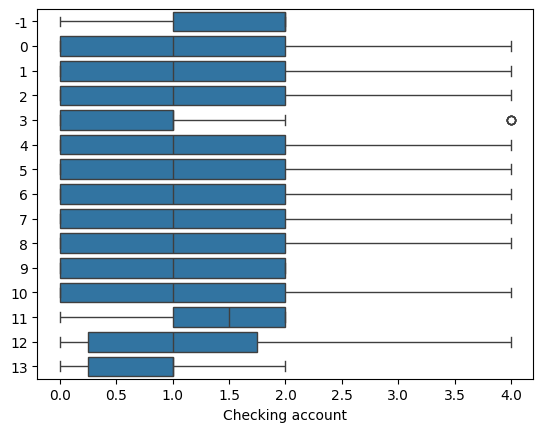

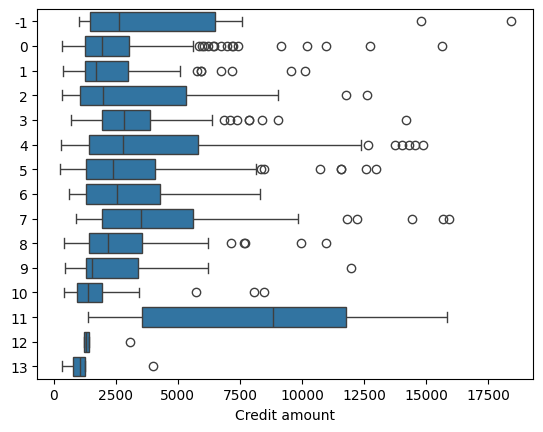

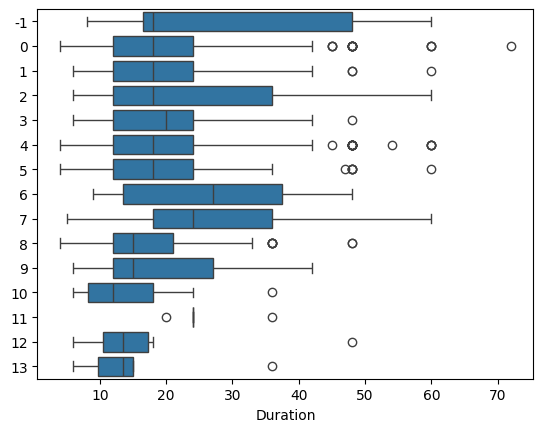

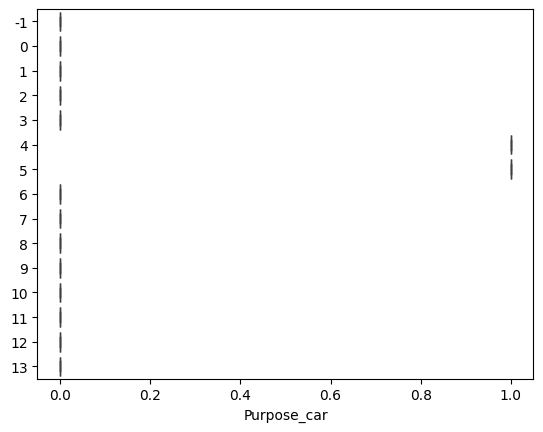

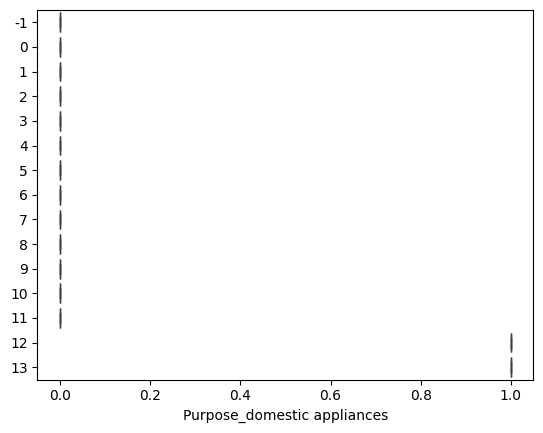

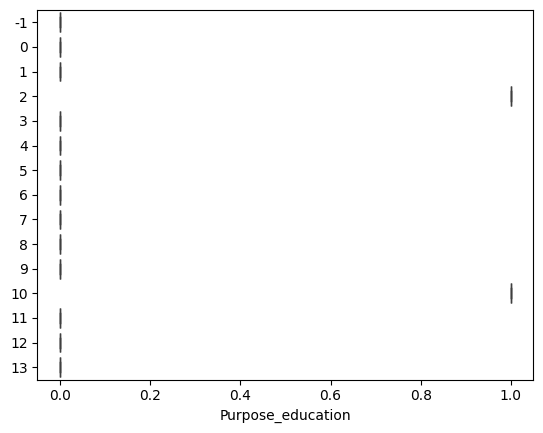

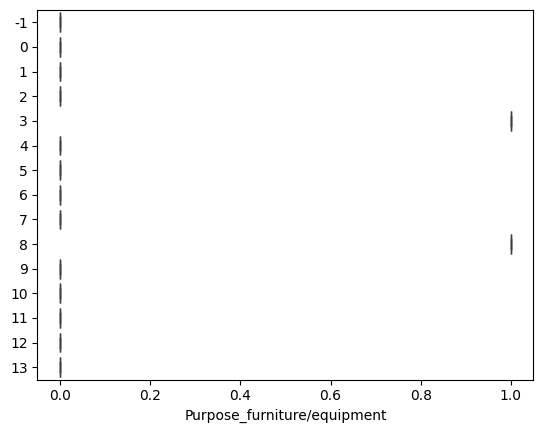

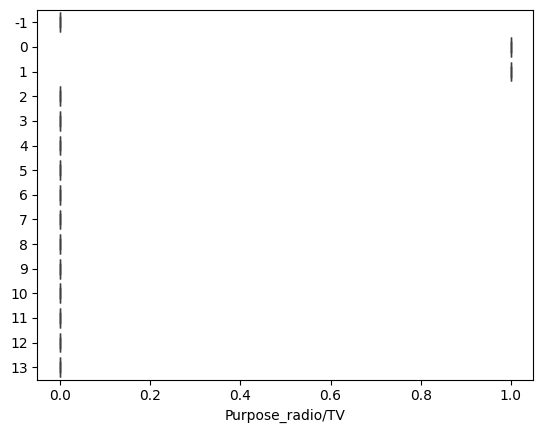

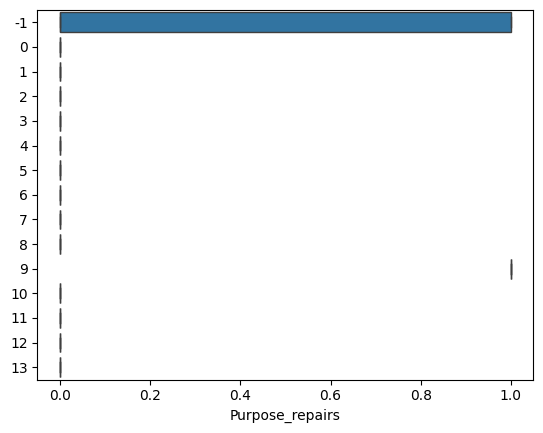

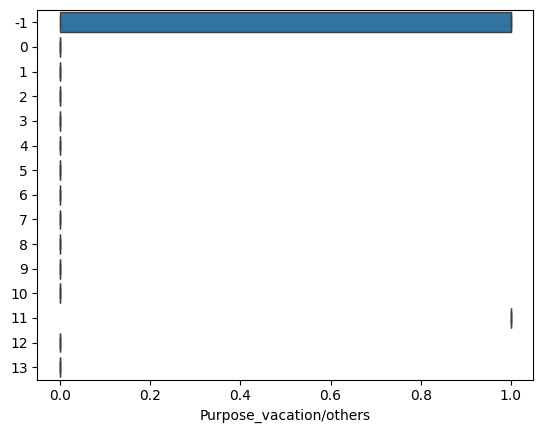

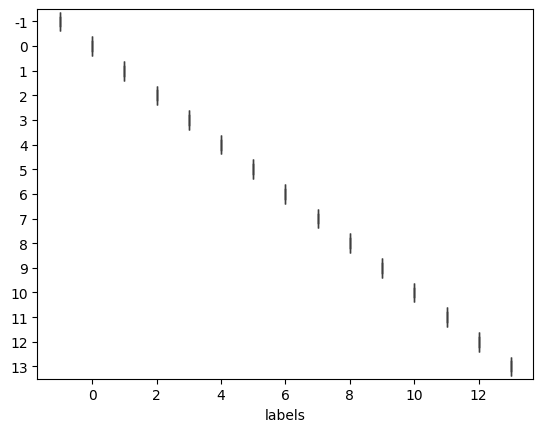

In [36]:
for col in df_enc_l.columns:
    sns.boxplot(data=df_enc_l, x=col, y=labels, orient='h')
    plt.show()

### Снижение размерности для визуализации <a class="anchor" id="red_dim"></a>

In [37]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=100)
X_tsne = tsne.fit_transform(X_scaled)


In [38]:
X_scaled.shape

(1000, 15)

In [39]:
X_tsne.shape

(1000, 2)

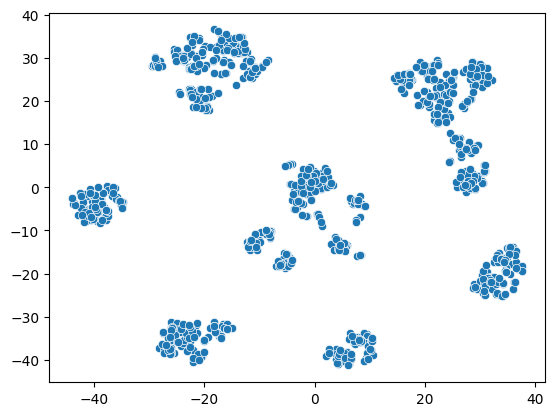

In [40]:
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1]);

Визуально выделяются 7 крупных кластеров. Странно, что ни один алгоритм не показал такое число, как оптимальное.